# **Team -11, Predicting Protein Interaction using GCNs on Yeast Dataset**

**Note:** This notebook uses CUDA v.10.1. If your PC is not supported, run this notebook on Colab with GPU settings turned on.

In [ ]:
!pip install stellargraph

In [ ]:
from stellargraph.data import EdgeSplitter

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score,roc_curve,auc,classification_report,precision_recall_curve
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import pandas as pd
import networkx as nx
import os
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
!pip install dgl-cu101

In [ ]:
import dgl
from dgl import DGLGraph
dgl.load_backend('pytorch')
from dgl.nn.pytorch import conv as dgl_conv

Using backend: pytorch
Using backend: pytorch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#**0. Data Loading and Splitting**

##**0.1 Load edgelist dataset into a Networkx Graph**

In [ ]:
raw_edge_list = open('/content/drive/My Drive/Colab Notebooks/DSLab/yeast.edgelist','r')
G = nx.Graph()
G = nx.parse_edgelist(raw_edge_list, delimiter='\t', create_using=G,nodetype=str, data=(('weight', float),))
# Get graph edges and nodes from networkx graph object
nodes = G.nodes
edges = G.edges

print("Graph's Nodes : {} / Edges : {}".format(len(nodes), len(edges)))

Graph's Nodes : 6526 / Edges : 532180


##**0.2 Protein names to integer values**

In [ ]:
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

##**0.3 Split graph into Train, Validation and Test set**

In [ ]:
es_test = EdgeSplitter(G)
graph_test, examples_test, link_labels_test = es_test.train_test_split(p=0.25, method="global")

** Sampled 133045 positive and 133045 negative edges. **


In [ ]:
es_train = EdgeSplitter(graph_test, G)
graph_train, examples_train, link_labels_train = es_train.train_test_split(p=0.25, method="global")
examples_train,examples_val, link_labels_train, link_label_val = train_test_split(examples_train,link_labels_train,test_size=0.033)

** Sampled 99783 positive and 99783 negative edges. **


#**1. GCN MODEL**

In [ ]:
class GCNModel(nn.Module):
    def __init__(self,in_feats,n_hidden,out_dim,layer_dim,hidden_layer_dim):
        super(GCNModel, self).__init__()
        

        self.gcn_layer_1 = dgl_conv.GraphConv(in_feats, n_hidden)

        self.gcn_layer_2 = dgl_conv.GraphConv(n_hidden, out_dim)

        self.lin_layer_1 = nn.Linear(out_dim, hidden_layer_dim)

        self.lin_layer_2 = nn.Linear(hidden_layer_dim,1)

    def forward(self, g, features, node_pairs, link_labels):
        x = features
        x = self.gcn_layer_1(g, features)
        x = F.relu(x)

        x = self.gcn_layer_2(g,x)
        x = F.relu(x)

        emb = x

        src = node_pairs[:,0]
        dst = node_pairs[:,1]

        emb_src = x[src]
        emb_dst = x[dst]

        z_tensor = torch.mul(emb_src,emb_dst)
        z_tensor = self.lin_layer_1(z_tensor)
        z_tensor = F.relu(z_tensor)
        z_tensor = self.lin_layer_2(z_tensor)
        sigm = nn.Sigmoid()
        z_tensor = sigm(z_tensor)
        return z_tensor.view(-1),emb
    
    def predict(self, features, g, node_pairs, link_labels):
        pred,emb = self.forward(features, g, node_pairs, link_labels)
        loss = nn.BCELoss()(pred, link_labels)
        return loss, pred,emb


##**1.1 Create Feature matrix**

In [ ]:
adj = nx.adjacency_matrix(graph_train)
features = np.identity(adj.shape[0])

(6526, 6526)

In [ ]:
class EdgeDataset(Dataset):
    def __init__(self, x, y):
        super(EdgeDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##**1.2 Training**

In [ ]:
def create_model_and_train(lr,batch_size,n_hidden,hidden_layer_dim):
  g = dgl.from_networkx(graph_train)
  g = dgl.add_self_loop(g)
  g.readonly()
  n_epochs=20
  out_dim = 80
  model = GCNModel(in_feats = features.shape[0],n_hidden=n_hidden,out_dim=out_dim,layer_dim=out_dim,hidden_layer_dim=hidden_layer_dim)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  traindata = EdgeDataset(examples_train, link_labels_train)
  edge_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
  print("Training for {} epochs.".format(n_epochs))

  eval_report = {
      'train_losses':[],
      'train_rocs':[],
      'train_aps':[],
      'val_losses':[],
      'val_rocs':[],
      'val_aps':[],
      'times_per_epoch':[],
      'epochs':[],
      'learning_rate': list(np.full((n_epochs,),lr)),
      'batch_size':list(np.full((n_epochs,),batch_size)),
      'hidden1_dim':list(np.full((n_epochs,),n_hidden)) ,
      'hidden_layer_dim':list(np.full((n_epochs,),hidden_layer_dim))
  }

  sigm_val_pred = []
  for epoch in range(n_epochs):
    eval_report['epochs'].append(epoch+1)
    t = time.time()
    print('\n', end='')
    
    loss = 0.0
    train_roc = 0.0
    train_ap = 0.0
    embed = []
    for i,data in enumerate(edge_loader):
      #print("Step {}/{}......".format(i+1,))
      pairs, edges = data
      pairs = Variable(pairs).cuda()
      edges = Variable(edges.float()).cuda()
      
      optimizer.zero_grad()
      loss, pred,embed = model.predict(g.to(device),torch.FloatTensor(features).cuda(), pairs, edges)
      loss.backward()
      optimizer.step()

      #pred = F.log_softmax(pred, dim=1)

      pred = pred.detach().to("cpu").numpy()
      #pred = 1*(pred>0.25)
      #pred = np.argmax(pred, axis=1)
      y_pred = []
      y_pred = np.append(y_pred, pred)
      train_roc = roc_auc_score(edges.detach().to("cpu").numpy(), y_pred)
      train_ap = average_precision_score(edges.detach().to("cpu").numpy(), y_pred)
      print("\repoch = {}/{} ({}/{}) - loss = {:.4f} roc_auc_score = {:.4f}"
      .format(epoch+1,n_epochs,i+1,int(examples_train.shape[0]/batch_size),
              loss,train_roc),end='',flush=True)
  
    eval_report['train_losses'].append(float(loss.detach().to('cpu').numpy()))
    eval_report['train_rocs'].append(train_roc)
    eval_report['train_aps'].append(train_ap)
    


    #validation scores
    val_loss, val_pred,_ = model.predict(g.to(device),torch.FloatTensor(features).cuda(), 
                                      torch.tensor(examples_val).cuda(), 
                                      torch.FloatTensor(link_label_val).cuda())
    #val_pred = F.log_softmax(val_pred, dim=1)
    val_pred = val_pred.detach().to("cpu").numpy()
    sigm_val_pred = val_pred
    #val_pred = np.argmax(val_pred, axis=1)
    #val_pred = 1*(val_pred>0.5)
    val_y_pred = []
    val_y_pred = np.append(val_y_pred, val_pred)
    val_roc = roc_auc_score(link_label_val, val_y_pred)
    val_ap = average_precision_score(link_label_val,val_y_pred)

    
    eval_report['val_losses'].append(float(val_loss.detach().to('cpu').numpy()))
    eval_report['val_rocs'].append(val_roc)
    eval_report['val_aps'].append(val_ap)
    eval_report['times_per_epoch'].append(float(time.time()-t))

    print("\repoch = {}/{} - loss = {:.4f} roc_auc_score = {:.4f} val_loss = {:.4f} val_roc_auc_score = {:.4f} val_avg_precision = {:.4f} time= {:.5f}"
    .format(epoch+1,n_epochs,loss,train_roc,val_loss,val_roc,val_ap, time.time()-t),end='',flush=False)
  return model,eval_report,sigm_val_pred,embed

In [ ]:
#generate a new csv (do not run every time)

#import pandas as pd
#df = pd.DataFrame(columns=['epochs','learning_rate','batch_size','hidden1_dim',
#                           'hidden_layer_dim','train_losses','train_rocs',
#                           'train_aps','val_losses','val_rocs','val_aps',
#                           'times_per_epoch'])
#df.to_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv')

In [ ]:
#Appending evaluation results to the CSV file

def append_to_csv(eval_report):
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv', index_col=0)
  df2 = pd.DataFrame({
    'epochs':eval_report['epochs'],
    'learning_rate':eval_report['learning_rate'],
    'batch_size':eval_report['batch_size'],
    'hidden1_dim':eval_report['hidden1_dim'],
    'hidden_layer_dim':eval_report['hidden_layer_dim'],
    'train_losses':eval_report['train_losses'],
    'train_rocs':eval_report['train_rocs'],
    'train_aps':eval_report['train_aps'],
    'val_losses':eval_report['val_losses'],
    'val_rocs':eval_report['val_rocs'],
    'val_aps':eval_report['val_aps'],
    'times_per_epoch':eval_report['times_per_epoch'],
  })
  df = pd.concat([df,df2],ignore_index=True)
  df.to_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv')

##**1.3 Evaluation**

In [ ]:
batch_s = 1024
model,eval_report,sigmoid_val_pred,embed = create_model_and_train(lr=0.01,batch_size=batch_s,n_hidden=256,hidden_layer_dim=16)
#append_to_csv(eval_report)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: DGLGraph.readonly is deprecated in v0.5.
DGLGraph now always supports mutable operations like add_nodes and add_edges.
  return warnings.warn(message, category=category, stacklevel=1)


Training for 20 epochs.

epoch = 1/20 - loss = 0.4247 roc_auc_score = 0.8910 val_loss = 0.4509 val_roc_auc_score = 0.8756 val_avg_precision = 0.8684 time= 15.46299
epoch = 2/20 - loss = 0.4125 roc_auc_score = 0.8904 val_loss = 0.4435 val_roc_auc_score = 0.8781 val_avg_precision = 0.8702 time= 15.01437
epoch = 3/20 - loss = 0.3953 roc_auc_score = 0.9014 val_loss = 0.4583 val_roc_auc_score = 0.8780 val_avg_precision = 0.8704 time= 15.21691
epoch = 4/20 - loss = 0.4295 roc_auc_score = 0.8802 val_loss = 0.4391 val_roc_auc_score = 0.8788 val_avg_precision = 0.8714 time= 15.20956
epoch = 5/20 - loss = 0.4262 roc_auc_score = 0.8807 val_loss = 0.4467 val_roc_auc_score = 0.8792 val_avg_precision = 0.8719 time= 15.11551
epoch = 6/20 - loss = 0.4422 roc_auc_score = 0.8714 val_loss = 0.4412 val_roc_auc_score = 0.8797 val_avg_precision = 0.8720 time= 15.13693
epoch = 7/20 - loss = 0.4500 roc_auc_score = 0.8699 val_loss = 0.4443 val_roc_auc_score = 0.8803 val_avg_precision = 0.8731 time= 14.92994
ep

In [ ]:
embed = embed.detach().to("cpu").numpy()

In [ ]:
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(embed)

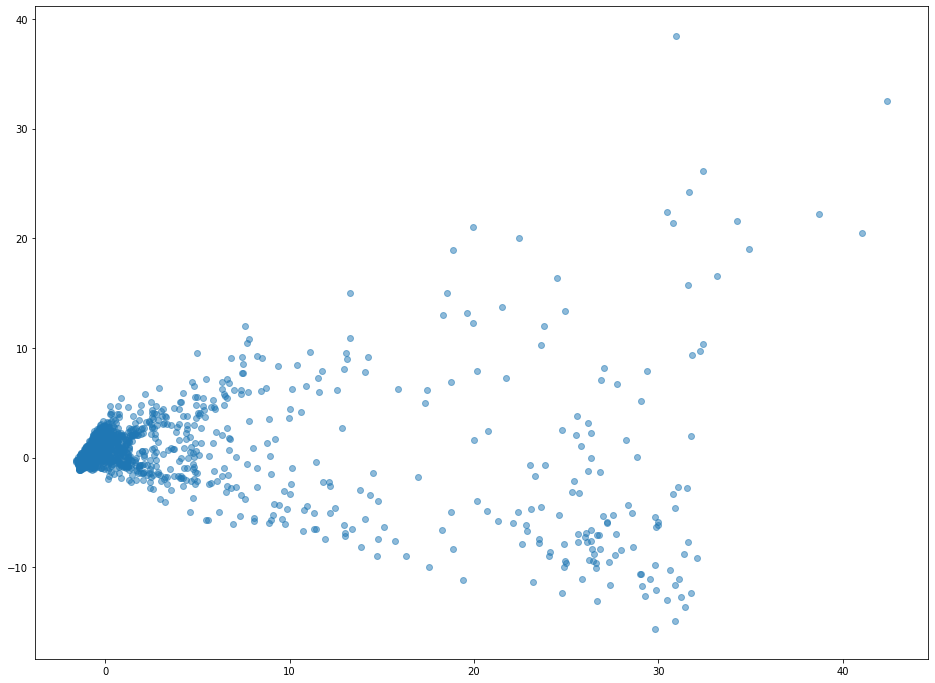

In [ ]:
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    #c=np.where(link_labels_train == 1, "b", "r"),
    alpha=0.5
)
plt.savefig('/content/drive/My Drive/Colab Notebooks/DSLab/eval/images/emb.jpeg')

###**1.3.1 Validation ROC curve**

In [ ]:
def plot_roc_curve(y_true,y_pred):
  fpr, tpr, thresholds = roc_curve(y_true,y_pred, pos_label=1)
  auc_roc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic on Validation Set')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1.1], [0, 1.1],'r--')
  plt.xlim([0, 1.1])
  plt.ylim([0, 1.1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

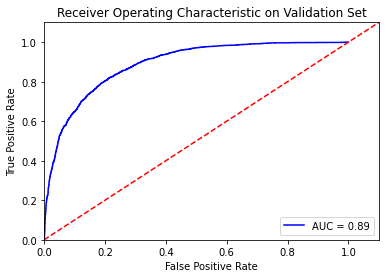

In [ ]:
plot_roc_curve(link_label_val,sigmoid_val_pred)

In [ ]:
testdata = EdgeDataset(examples_test,link_labels_test)
test_loader = DataLoader(testdata, batch_size=batch_s, shuffle=False)

##**1.4 Link Prediction on test graph**

In [ ]:
g_test = dgl.from_networkx(graph_test)
g_test = dgl.add_self_loop(g_test)
test_preds = []
test_true = []
test_losses = []
for i,Data in enumerate(test_loader):
  node_pairs, labels_test = Data
  
  with torch.no_grad():
    test_loss, test_pred,embed = model.predict(g_test.to(device),torch.FloatTensor(features).cuda(), torch.tensor(node_pairs).cuda(), labels_test.float().cuda())
    
    test_losses.append(test_loss)
    test_pred = test_pred.detach().to("cpu").numpy()
    #test_pred = 1*(test_pred>0.5)
    
    test_preds = np.append(test_preds, test_pred)
    test_true = np.append(test_true,labels_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


###**1.4.1 Scores**

In [ ]:
test_roc = roc_auc_score(test_true, test_preds)
test_ap = average_precision_score(test_true,test_preds)
print("Test ROC AUC Score = {:.4f}\nTest Average Precision Score = {:.4f}".format(test_roc,test_ap))

Test ROC AUC Score = 0.8919
Test Average Precision Score = 0.8821


###**1.4.2 Test ROC Curve**

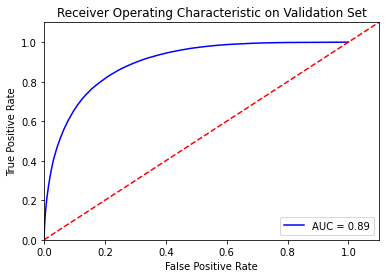

In [ ]:
plot_roc_curve(test_true,test_preds)

###**1.4.3 Test Precision Recall Curve**

In [ ]:
precision, recall, thresholds = precision_recall_curve(test_true, test_preds)

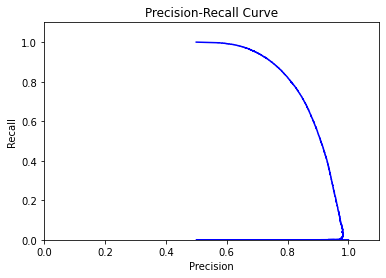

In [ ]:
plt.title('Precision-Recall Curve')
plt.plot(precision,recall, 'b')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()

###**1.4.4 Test classification report**

In [ ]:
cr = classification_report(test_true,test_preds.round())
print(cr)

              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81    133045
         1.0       0.82      0.78      0.80    133045

    accuracy                           0.81    266090
   macro avg       0.81      0.81      0.81    266090
weighted avg       0.81      0.81      0.81    266090



#**2. BASELINE MODEL**

In [ ]:
!pip install node2vec

In [ ]:
from node2vec import Node2Vec
from stellargraph import StellarGraph

In [ ]:
graph_train_sg = StellarGraph.from_networkx(graph_train)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

##**2.1 Logistic Regression model for Link Prediction**

In [ ]:
lr_clf = LogisticRegression(max_iter=185)
p = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])

##**2.2 Node2Vec Model to learn node features of train graph**

In [ ]:
node2vec = Node2Vec(graph_train, dimensions=80, walk_length=20, num_walks=10,p=0.25,q=0.25)
model = node2vec.fit(window=10, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:05<00:00,  6.55s/it]


##**2.3 Convert node features to edge features (Train set)**

In [ ]:
train_emb = []
for src,dst in examples_train:
  b = (model.wv.get_vector(str(src)) + model.wv.get_vector(str(dst)))/2.0
  train_emb.append(b)

##**2.4 Link Prediction Model Training and Evaluation**

In [ ]:
clf = p
clf.fit(train_emb, link_labels_train)
val_emb = []
for src,dst in examples_val:
  b = (model.wv.get_vector(str(src)) + model.wv.get_vector(str(dst)))/2.0
  val_emb.append(b)
val_pred = clf.predict(val_emb)
val_prob = clf.predict_proba(val_emb)
roc = roc_auc_score(link_label_val, val_pred)
ap = average_precision_score(link_label_val, val_pred)
print("Validation ROC AUC Score = ",roc)
print("Validation Average Precision Score = ",ap)

Validation ROC AUC Score =  0.7103501228501229
Validation Average Precision Score =  0.6397305185107002


##**2.5 Node2Vec Model to learn node features of test graph**

In [ ]:
node2vec_test = Node2Vec(graph_test, dimensions=80, walk_length=20, num_walks=10,p=0.25,q=0.25)
model_test = node2vec.fit(window=10, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:13<00:00,  7.31s/it]


##**2.6 Predict Test graph edges**

In [ ]:
test_emb = []
for src,dst in examples_test:
  b = (model_test.wv.get_vector(str(src)) + model_test.wv.get_vector(str(dst)))/2.0
  test_emb.append(b)
test_pred = clf.predict(test_emb)
roc_test = roc_auc_score(link_labels_test, test_pred)
ap_test = average_precision_score(link_labels_test, test_pred)
print("Validation ROC AUC Score = ",roc_test)
print("Validation Average Precision Score = ",ap_test)

Validation ROC AUC Score =  0.7084896087789845
Validation Average Precision Score =  0.6434994387904145
